In [2]:
from __future__ import annotations
import torch
import gym
import numpy as np
from GAIL import GAIL
import matplotlib.pyplot as plt
import utils
import Q_Learning_agnet
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall, Lava
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.wrappers import RGBImgObsWrapper
from minigrid.wrappers import OneHotPartialObsWrapper
from minigrid.wrappers import FullyObsWrapper
from minigrid.wrappers import ImgObsWrapper
from minigrid.wrappers import FlatObsWrapper
import numpy as np
from minigrid.core.actions import Actions
import gymnasium as gym
import pygame
from minigrid.wrappers import SymbolicObsWrapper
from minigrid.wrappers import NoDeath

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(5, i, Wall())
        
        # Place the door and key
        self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(3, 6, Key(COLOR_NAMES[0]))
        self.grid.set(2, 6, Lava())
        self.grid.set(2, 5, Lava())
        self.grid.set(3, 1, Lava())
        self.grid.set(4, 1, Lava())
        self.grid.set(3, 4, Lava())
        self.grid.set(7, 7, Lava())

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, height - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

In [4]:
key_to_action = {
    "forward": Actions.forward,
    "left": Actions.left,
    "right": Actions.right,
    "toggle": Actions.toggle,
    "pickup": Actions.pickup,
    "drop": Actions.drop,
} 

In [5]:
######### Hyperparameters #########
file_path = "near_optimal_pose_auto_annotated.txt"
#env_name = "LunarLanderContinuous-v2"
solved_reward = 0.2        # stop training if solved_reward > avg_reward
random_seed = 0
max_timesteps = 200        # max time steps in one episode
n_eval_episodes = 200        # evaluate average reward over n episodes
lr = 0.0002                 # learing rate
betas = (0.5, 0.999)        # betas for adam optimizer
n_epochs = 10000             # number of epochs
n_iter = 100                # updates per epoch
n_test = 100                # run test n_test times
batch_size = 1            # num of transitions sampled from expert
###################################

env = SimpleEnv()
#env = FlatObsWrapper(env)
# enable manual control for testing
env = SymbolicObsWrapper(env)
env = NoDeath(env, no_death_types=("lava",), death_cost=-0.4)


state_dim = 3
action_dim = 1
max_action = 6

epochs = []
rewards = []
env.reset()

reward_agent = Q_Learning_agnet.QLAgent(action_space= 7)
progress_agent = Q_Learning_agnet.QLAgent(action_space= 7)
imitator = Q_Learning_agnet.QLAgent(action_space= 7)
expert_traj = utils.ExpertTraj(file_path, reward = True, progress = True)
for epoch in range(n_epochs):
    state, action, next_state, reward, progress = expert_traj.sample(batch_size, reward = True, progress = True )
    #print(state, action, next_state, reward, progress)
    reward_agent.learning(state, action, next_state, reward)
    progress_agent.learning(state, action, next_state, progress)
    imitator.learning(state, action, next_state, 1)

rewards = []
progresses = []
imitations = []

for i in range(1, 9):
    rewards.append([])
    progresses.append([])
    imitations.append([])
    for j in range(1, 9):
        max_reward = -100
        max_progress = -100
        max_imitation = -100
        for k in range(0, 7):
            for l in range(0, 2):
                for m in range(0, 2):
                    reward_agent.check_add([i, j, k, l, m])
                    max_reward = max(max_reward, reward_agent.qtable.loc[reward_agent.trans([i, j, k, l, m])].max())
                    progress_agent.check_add([i, j, k, l, m])
                    max_progress = max(max_progress, progress_agent.qtable.loc[progress_agent.trans([i, j, k, l, m])].max())
                    imitator.check_add([i, j, k, l, m])
                    max_imitation = max(max_imitation, imitator.qtable.loc[imitator.trans([i, j, k, l, m])].max())
        rewards[-1].append(max_reward)
        progresses[-1].append(max_progress)
        imitations[-1].append(max_imitation)


C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.grid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid` for environment variables or `env.get_wrapper_attr('grid')` that will search the reminding wrappers.
  logger.warn(
C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Pyt

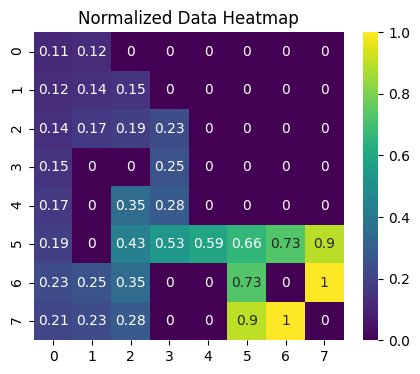

In [11]:


data = np.array(rewards)
data = np.rot90(data)
data = np.flip(data, 0)

# Normalize the data
data_min = np.min(data)
data_max = np.max(data)
normalized_data = (data - data_min) / (data_max - data_min)
# normalized_data = np.rot90(normalized_data)
# normalized_data = np.rot90(normalized_data)
# normalized_data = np.rot90(normalized_data)
# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(normalized_data, cmap='viridis', annot=True)
plt.title('Normalized Data Heatmap')
plt.show()

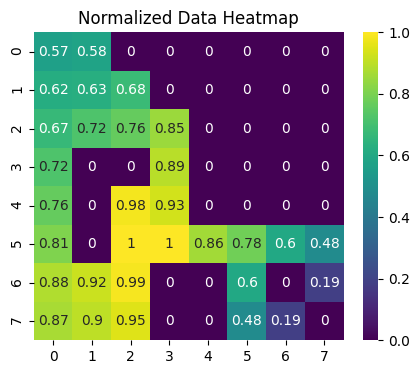

In [12]:


data = np.array(progresses)
data = np.rot90(data)
data = np.flip(data, 0)

# Normalize the data
data_min = np.min(data)
data_max = np.max(data)
normalized_data = (data - data_min) / (data_max - data_min)
# normalized_data = np.rot90(normalized_data)
# normalized_data = np.rot90(normalized_data)
# normalized_data = np.rot90(normalized_data)
# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(normalized_data, cmap='viridis', annot=True)
plt.title('Normalized Data Heatmap')
plt.show()

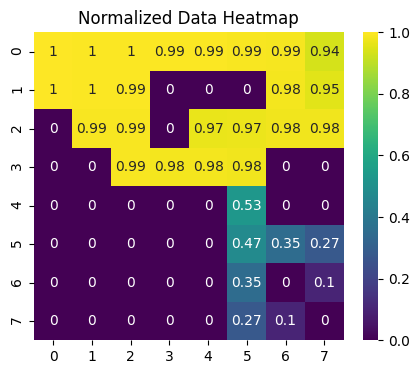

In [9]:


data = np.array(imitations)
data = np.rot90(data)
data = np.flip(data, 0)

# Normalize the data
data_min = np.min(data)
data_max = np.max(data)
normalized_data = (data - data_min) / (data_max - data_min)
# normalized_data = np.rot90(normalized_data)
# normalized_data = np.rot90(normalized_data)
# normalized_data = np.rot90(normalized_data)
# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(normalized_data, cmap='viridis', annot=True)
plt.title('Normalized Data Heatmap')
plt.show()